In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import models.rf as rf
import models.tools as models_tools
import data_utils.data_analysis as data_analysis

#from sklearn.model_selection import train_test_split

In [2]:
#READ THE DATASET
#240314
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input_240314,df_time_val_240314,df_time_240314,df_freq_val_240314,df_freq_int_240314 = data_analysis.read_dataset(filename)

filename='datasets/galadriel_dataset_24_04_11.h5'
df_input_240411,df_time_val_240411,df_time_240411,df_freq_val_240411,df_freq_int_240411 = data_analysis.read_dataset(filename)

filename='datasets/galadriel_dataset_24_05_09.h5'
df_input_240509,df_time_val_240509,df_time_240509,df_freq_val_240509,df_freq_int_240509 = data_analysis.read_dataset(filename)

#READ THE DATASET 24_06_06
filename='datasets/galadriel_dataset_24_06_06.h5'
df_input_240606,df_time_val_240606,df_time_240606,df_freq_val_240606,df_freq_int_240606 = data_analysis.read_dataset(filename)


Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [3]:
#Add an extra column for the time to eb consistent with first dataset
#240411
df_time_val_240411=pd.concat([df_time_val_240411,pd.Series([94.466],dtype='float64')],ignore_index=True)
df_time_240411['18']=0.000
df_time_240411.columns=df_time_240411.columns.astype(str)

#240509
shift_col=np.linspace(1,17,17,dtype='int')
df_time_240509.columns=shift_col
df_time_240509.insert(0,'0',0.0)
df_time_240509.insert(18,'18',0.0)

df_time_val_240509=pd.concat([pd.Series([-94.466],dtype='float64'),df_time_val_240509],ignore_index=True)
df_time_val_240509=pd.concat([df_time_val_240509,pd.Series([94.466],dtype='float64')],ignore_index=True)
df_time_240509.columns=df_time_240509.columns.astype(str)

In [4]:
#CLEAN SHOTS
#240314
minval=8000
df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314=data_analysis.clean_shots_below(minval,df_input_240314,df_time_240314,df_freq_int_240314)
#240411
maxval=65000
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411=data_analysis.clean_shots_above(maxval,df_input_240411,df_time_240411,df_freq_int_240411)
#240509
minval=6000
df_input_clean_240509,df_time_clean_240509,df_freq_int_clean_240509=data_analysis.clean_shots_below(minval,df_input_240509,df_time_240509,df_freq_int_240509)



Shots with max val below this will be discarded: 8000


Shots with max val above this will be discarded: 65000


Shots with max val below this will be discarded: 6000



### Train the model

In [5]:
def train_roundtrip(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18

    #train roadtrip model
    rf_model_forward,rf_model_backward = models_tools.train_roundtrip_rf(X_train, X_test, y_train, y_test,
                                                            n_estimators, max_features,max_depth, random_state)
    #roundtrip prediction
    y_predict_roundtrip=models_tools.roundtrip_predict(y_test,rf_model_backward,rf_model_forward)
    
    #study the erro distribution
    df_error_roundtrip_forest=abs(y_test_reset-y_predict_roundtrip)
    df_error_roundtrip_forest=df_error_roundtrip_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return df_error_roundtrip_forest,rf_model_forward,rf_model_backward

In [6]:
#240314
df_error_240314,model_forward_240314,model_backward_240314=train_roundtrip(df_input_clean_240314,df_time_clean_240314)
#240411
df_error_240411,model_forward_240411,model_backward_240411=train_roundtrip(
    df_input_clean_240411,df_time_clean_240411)
#240509
df_error_240509,model_forward_240509,model_backward_240509=train_roundtrip(
    df_input_clean_240509,df_time_clean_240509)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [7]:
#240606
df_error_240606,model_forward_240606,model_backward_240606=train_roundtrip(
    df_input_240606,df_time_240606)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


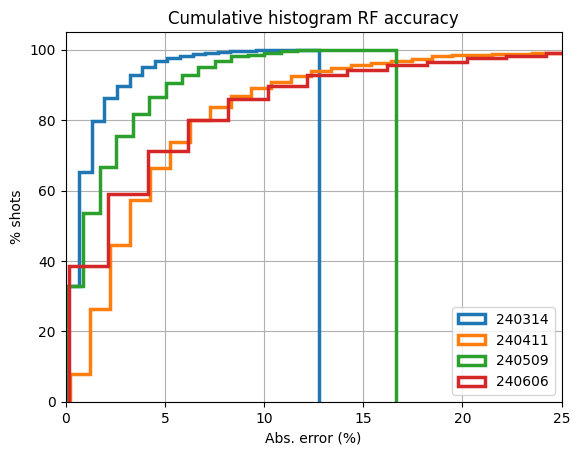

In [8]:
weights_240314 = 100*np.ones_like(df_error_240314) / len(df_error_240314)
weights_240411 = 100*np.ones_like(df_error_240411) / len(df_error_240411)
weights_240509 = 100*np.ones_like(df_error_240509) / len(df_error_240509)
weights_240606 = 100*np.ones_like(df_error_240606) / len(df_error_240606)
(100*df_error_240314).hist(bins=20,weights=weights_240314,cumulative=True,histtype="step",linewidth=2.5,label='240314')
(100*df_error_240411).hist(bins=40,weights=weights_240411,cumulative=True,histtype="step",linewidth=2.5,label='240411')
(100*df_error_240509).hist(bins=20,weights=weights_240509,cumulative=True,histtype="step",linewidth=2.5,label='240509')
(100*df_error_240606).hist(bins=20,weights=weights_240606,cumulative=True,histtype="step",linewidth=2.5,label='240606')

plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,25)
plt.legend()
plt.show()

# Predictions without trainig (using first day model 240314)

In [9]:
def error_dist(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error)

    #print('ID max error:',df_error.idxmax())
    #print('Max error:',df_error.max())
    return df_error

In [10]:
#define the targets and inputs for aeach dataset
#240411
X_240411=df_input_clean_240411[['order2','order3','order4']]
y_240411=df_time_clean_240411
#split into train and test set
X_train_240411, X_test_240411, y_train_240411, y_test_240411 = train_test_split(X_240411, y_240411, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240411=y_test_240411.reset_index(drop=True)

#240509
X_240509=df_input_clean_240509[['order2','order3','order4']]
y_240509=df_time_clean_240509
#split into train and test set
X_train_240509, X_test_240509, y_train_240509, y_test_240509 = train_test_split(X_240509, y_240509, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240509=y_test_240509.reset_index(drop=True)

NameError: name 'train_test_split' is not defined

In [ ]:
#Prediction for #DATASET 240411
#backward
X_predict_backward_old_240411=rf.make_rf_prediction(model_backward_240314,y_test_240411)
#forward
y_predict_roundtrip_old_240411=model_forward_240314.predict(X_predict_backward_old_240411)

#Prediction for #DATASET 240509
#backward
X_predict_backward_old_240509=rf.make_rf_prediction(model_backward_240314,y_test_240509)
#forward
y_predict_roundtrip_old_240509=model_forward_240314.predict(X_predict_backward_old_240509)

In [ ]:
df_error_old_240411=error_dist(y_predict_roundtrip_old_240411,y_test_reset_240411)
df_error_old_240509=error_dist(y_predict_roundtrip_old_240509,y_test_reset_240509)

In [ ]:
weights_240411 = 100*np.ones_like(df_error_240411) / len(df_error_240411)
weights_240509 = 100*np.ones_like(df_error_240509) / len(df_error_240509)
(100*df_error_240411).hist(bins=40,weights=weights_240411,cumulative=True,histtype="step",linewidth=2.5,color='g',label='240411 (New model)')
(100*df_error_old_240411).hist(bins=40,weights=weights_240411,cumulative=True,histtype="step",linewidth=2.5,color='g',linestyle='--',label='240411 (Old model)')
(100*df_error_240509).hist(bins=20,weights=weights_240509,cumulative=True,histtype="step",linewidth=2.5,color='b',label='240509 (New model)')
(100*df_error_old_240509).hist(bins=20,weights=weights_240509,cumulative=True,histtype="step",linewidth=2.5,linestyle='--',color='b',label='240509 (Old model)')

plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,25)
plt.legend()
plt.show()